#libraries

In [2]:
# Import necessary libraries
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, mean_squared_error
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.neural_network import MLPClassifier, MLPRegressor
from sklearn.svm import SVC, SVR
import joblib
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns


In [3]:
from google.colab import drive

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Data Loading Section

In [4]:
#Load training and test datasets. Replace 'train_data.csv' and 'test_data.csv' with actual file paths.
train_data = pd.read_csv('/content/drive/My Drive/Train_data.csv')
test_data = pd.read_csv('/content/drive/My Drive/Test_data.csv')

In [5]:
# Display basic info about the training data
train_data.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25192 entries, 0 to 25191
Data columns (total 42 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   duration                     25192 non-null  int64  
 1   protocol_type                25192 non-null  object 
 2   service                      25192 non-null  object 
 3   flag                         25192 non-null  object 
 4   src_bytes                    25192 non-null  int64  
 5   dst_bytes                    25192 non-null  int64  
 6   land                         25192 non-null  int64  
 7   wrong_fragment               25192 non-null  int64  
 8   urgent                       25192 non-null  int64  
 9   hot                          25192 non-null  int64  
 10  num_failed_logins            25192 non-null  int64  
 11  logged_in                    25192 non-null  int64  
 12  num_compromised              25192 non-null  int64  
 13  root_shell      

In [6]:
# Display basic info about the training data
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22544 entries, 0 to 22543
Data columns (total 41 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   duration                     22544 non-null  int64  
 1   protocol_type                22544 non-null  object 
 2   service                      22544 non-null  object 
 3   flag                         22544 non-null  object 
 4   src_bytes                    22544 non-null  int64  
 5   dst_bytes                    22544 non-null  int64  
 6   land                         22544 non-null  int64  
 7   wrong_fragment               22544 non-null  int64  
 8   urgent                       22544 non-null  int64  
 9   hot                          22544 non-null  int64  
 10  num_failed_logins            22544 non-null  int64  
 11  logged_in                    22544 non-null  int64  
 12  num_compromised              22544 non-null  int64  
 13  root_shell      

#Exploratory Data Analysis

In [7]:
# Basic statistics and visualization
print(train_data.describe())



           duration     src_bytes     dst_bytes          land  wrong_fragment  \
count  25192.000000  2.519200e+04  2.519200e+04  25192.000000    25192.000000   
mean     305.054104  2.433063e+04  3.491847e+03      0.000079        0.023738   
std     2686.555640  2.410805e+06  8.883072e+04      0.008910        0.260221   
min        0.000000  0.000000e+00  0.000000e+00      0.000000        0.000000   
25%        0.000000  0.000000e+00  0.000000e+00      0.000000        0.000000   
50%        0.000000  4.400000e+01  0.000000e+00      0.000000        0.000000   
75%        0.000000  2.790000e+02  5.302500e+02      0.000000        0.000000   
max    42862.000000  3.817091e+08  5.151385e+06      1.000000        3.000000   

            urgent           hot  num_failed_logins     logged_in  \
count  25192.00000  25192.000000       25192.000000  25192.000000   
mean       0.00004      0.198039           0.001191      0.394768   
std        0.00630      2.154202           0.045418      0.4888

# Task Identification

In [8]:
# Display the first few values of the target column to identify the type of task
print(train_data["class"].head())

# Display unique values of the target column to understand the problem better
print(train_data["class"].unique())

0     normal
1     normal
2    anomaly
3     normal
4     normal
Name: class, dtype: object
['normal' 'anomaly']


In [9]:
# Function to identify whether the task is classification or regression based on the target column
def identify_task(train_data, target_column):
    """
    Identifies the type of task (classification or regression) based on the target column.
    If the number of unique values in the target column is less than or equal to 10, it is classified as a classification task.
    """
    if train_data[target_column].nunique() <= 10:
        return "classification"
    return "regression"

In [10]:
# Define the target column and identify the task type
target_column = "class"
task_type = identify_task(train_data, target_column)
print(f"Identified Task: {task_type}")


Identified Task: classification


# Feature Preprocessing

In [11]:
# Separate features and target, and identify categorical columns for encoding
features = [col for col in train_data.columns if col != target_column]


#categorical_columns = [col for col in train_data.select_dtypes(include=['object']).columns if col != target_column]
categorical_columns = train_data.select_dtypes(include=['object']).columns
categorical_columns = [col for col in categorical_columns if col != target_column]
print("Categorical Columns:", categorical_columns)




Categorical Columns: ['protocol_type', 'service', 'flag']


In [12]:
# Perform label encoding for categorical features

encoder = LabelEncoder()
if len(categorical_columns) > 0:
    for column in categorical_columns:
        combined_data = pd.concat([train_data[column], test_data[column]], axis=0)
        # Fit the encoder on the combined data
        encoder.fit(combined_data)

        # Transform the train and test data
        train_data[column] = encoder.transform(train_data[column])
        test_data[column] = encoder.transform(test_data[column])

numerical_columns = test_data.select_dtypes(include=['int64', 'float64']).columns
for col in numerical_columns:
    if not pd.api.types.is_numeric_dtype(test_data[col]):
        print(f"Column '{col}' contains non-numeric data. Converting or removing invalid entries...")
        # Convert non-numeric to NaN
        test_data[col] = pd.to_numeric(test_data[col], errors='coerce')

# Fill missing values introduced by non-numeric entries
test_data[numerical_columns] = test_data[numerical_columns].fillna(test_data[numerical_columns].mean())


test_data


,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate
0,0,1,46,1,0,0,0,0,0,0,...,255,10,0.04,0.06,0.00,0.00,0.00,0.0,1.00,1.00
1,0,1,46,1,0,0,0,0,0,0,...,255,1,0.00,0.06,0.00,0.00,0.00,0.0,1.00,1.00
2,2,1,19,9,12983,0,0,0,0,0,...,134,86,0.61,0.04,0.61,0.02,0.00,0.0,0.00,0.00
3,0,0,13,9,20,0,0,0,0,0,...,3,57,1.00,0.00,1.00,0.28,0.00,0.0,0.00,0.00
4,1,1,57,2,0,15,0,0,0,0,...,29,86,0.31,0.17,0.03,0.02,0.00,0.0,0.83,0.71
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22539,0,1,51,9,794,333,0,0,0,0,...,100,141,0.72,0.06,0.01,0.01,0.01,0.0,0.00,0.00
22540,0,1,22,9,317,938,0,0,0,0,...,197,255,1.00,0.00,0.01,0.01,0.01,0.0,0.00,0.00
22541,0,1,22,9,54540,8314,0,0,0,2,...,255,255,1.00,0.00,0.00,0.00,0.00,0.0,0.07,0.07
22542,0,2,11,9,42,42,0,0,0,0,...,255,252,0.99,0.01,0.00,0.00,0.00,0.0,0.00,0.00


# Data Splitting

In [13]:
# Split the training data into training and validation sets.

X = train_data.drop('class', axis=1)
y = train_data[target_column]
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)


# Feature Scaling

In [14]:
# Standardize numerical features to improve model performance.
scaler = StandardScaler()
numerical_columns = train_data.select_dtypes(include=['int64', 'float64']).columns

print(numerical_columns)
for col in numerical_columns:
    if not pd.api.types.is_numeric_dtype(X_train[col]):
        print(f"Column '{col}' contains non-numeric data. Converting or removing invalid entries...")
        # Convert non-numeric to NaN
        X_train[col] = pd.to_numeric(X_train[col], errors='coerce')

# Fill missing values introduced by non-numeric entries
X_train[numerical_columns] = X_train[numerical_columns].fillna(X_train[numerical_columns].mean())


X_train[numerical_columns] = scaler.fit_transform(X_train[numerical_columns])
X_val[numerical_columns] = scaler.transform(X_val[numerical_columns])
test_data[numerical_columns] = scaler.transform(test_data[numerical_columns])

Index(['duration', 'protocol_type', 'service', 'flag', 'src_bytes',
       'dst_bytes', 'land', 'wrong_fragment', 'urgent', 'hot',
       'num_failed_logins', 'logged_in', 'num_compromised', 'root_shell',
       'su_attempted', 'num_root', 'num_file_creations', 'num_shells',
       'num_access_files', 'num_outbound_cmds', 'is_host_login',
       'is_guest_login', 'count', 'srv_count', 'serror_rate',
       'srv_serror_rate', 'rerror_rate', 'srv_rerror_rate', 'same_srv_rate',
       'diff_srv_rate', 'srv_diff_host_rate', 'dst_host_count',
       'dst_host_srv_count', 'dst_host_same_srv_rate',
       'dst_host_diff_srv_rate', 'dst_host_same_src_port_rate',
       'dst_host_srv_diff_host_rate', 'dst_host_serror_rate',
       'dst_host_srv_serror_rate', 'dst_host_rerror_rate',
       'dst_host_srv_rerror_rate'],
      dtype='object')


# Baseline Performance

In [15]:
# Compute a baseline performance metric to compare models against.
if task_type == "classification":
    most_common_label = y_train.mode()[0]
    baseline_predictions = [most_common_label] * len(y_val)
    baseline_score = accuracy_score(y_val, baseline_predictions)
    print(f"Baseline Accuracy: {baseline_score:.4f}")
else:
    baseline_prediction = y_train.mean()
    baseline_predictions = [baseline_prediction] * len(y_val)
    baseline_score = mean_squared_error(y_val, baseline_predictions, squared=False)
    print(f"Baseline RMSE: {baseline_score:.4f}")

Baseline Accuracy: 0.5307


# Model Selection and Training

In [16]:
# Define models for classification and regression tasks.
models = {
    "classification": [
        RandomForestClassifier(random_state=42),
        SVC(random_state=42, probability=True),
        MLPClassifier(random_state=42, max_iter=500)
    ],
    "regression": [
        RandomForestRegressor(random_state=42),
        SVR(),
        MLPRegressor(random_state=42, max_iter=500)
    ]
}

In [17]:
# Train models and select the best-performing one based on validation performance.
best_model = None
best_score = float('-inf') if task_type == "classification" else float('inf')

for model in models[task_type]:
    model.fit(X_train, y_train)
    y_val_pred = model.predict(X_val)

    if task_type == "classification":
        score = accuracy_score(y_val, y_val_pred)
        print(f"Model: {model.__class__.__name__}, Accuracy: {score:.4f}")
        if score > best_score:
            best_score = score
            best_model = model
    else:
        score = mean_squared_error(y_val, y_val_pred, squared=False)
        print(f"Model: {model.__class__.__name__}, RMSE: {score:.4f}")
        if score < best_score:
            best_score = score
            best_model = model

print(f"Best Model: {best_model.__class__.__name__}")

Model: RandomForestClassifier, Accuracy: 0.9978
Model: SVC, Accuracy: 0.9903
Model: MLPClassifier, Accuracy: 0.9940
Best Model: RandomForestClassifier


Model evaluation

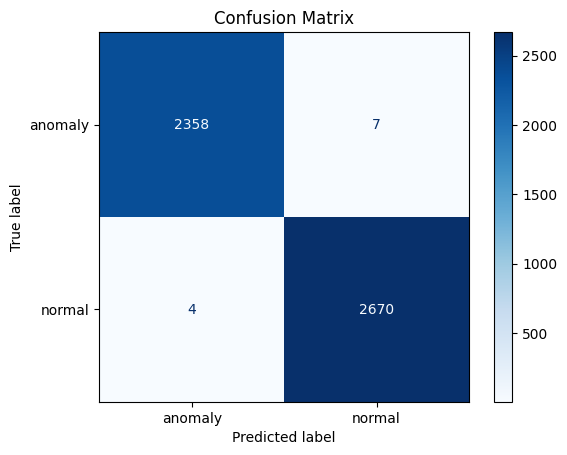

In [21]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Compute and display the confusion matrix
conf_matrix = confusion_matrix(y_val, best_model.predict(X_val))
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=best_model.classes_)
disp.plot(cmap="Blues", values_format="d")
plt.title("Confusion Matrix")
plt.show()


In [18]:
# Test Data Predictions
# We predict on test data without a target column
test_predictions = best_model.predict(test_data[features])

# Save predictions for external evaluation
output = pd.DataFrame({"Id": test_data.index, "Predicted": test_predictions})
output.to_csv("test_predictions.csv", index=False)
print("Test predictions saved to 'test_predictions.csv'.")

Test predictions saved to 'test_predictions.csv'.


# Model Deployment

In [19]:
# Make predictions on the test dataset using the best model.
test_predictions = best_model.predict(test_data)

# Save predictions to a CSV file
output = pd.DataFrame({"Id": test_data.index, "Predicted": test_predictions})
output.to_csv("test_predictions.csv", index=False)


# Save Best Model

In [20]:
# Save the best model to a file for future use.
joblib.dump(best_model, "best_model.pkl")

['best_model.pkl']